# Predicting King County Housing Prices

This project takes the data for houses in King County Washington in order to predict home prices based upon various features. We use linear regression modeling on various features in order to predict these prices.

The stakeholder for this project is a commercial real estate company looking to purchase homes in a given area. They are primarily interested in: what zipcodes have the lowest prices, predicted prices of homes in the area, and any relevant differences between the real prices and our model's predicted price.

## Import Libraries and Data

In [1]:
# data manipulation
import pandas as pd
import numpy as np
import json

# statistical analysis and modeling 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
import scipy.stats as stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import folium
%matplotlib inline

In [2]:
# Import the data
df = pd.read_csv('data/kc_house_data.csv')

## Data Cleaning 

Replace categorical values with numeric data types. 

In [3]:
# assign new variables to relevent columns
df.date =  pd.to_datetime(df.date, format='%m/%d/%Y')
df.waterfront.replace({'NO': 0, 'YES': 1}, inplace=True)
df.view.replace({'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}, inplace=True)
df.condition.replace({'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}, inplace=True)
df.grade.replace({'3 Poor': 0, '4 Low': 1, '5 Fair': 2, '6 Low Average': 3, '7 Average': 4, '8 Good': 5, 
                  '9 Better': 6, '10 Very Good': 7, '11 Excellent': 8, '12 Luxury': 9, '13 Mansion': 10}, 
                 inplace=True)
df.sqft_basement.replace('?', np.NaN, inplace=True)
df.sqft_basement = df.sqft_basement.astype(float)


## Data Analysis

Create a heat map to show the correlation of every column to decide which features are usuful in a model. 

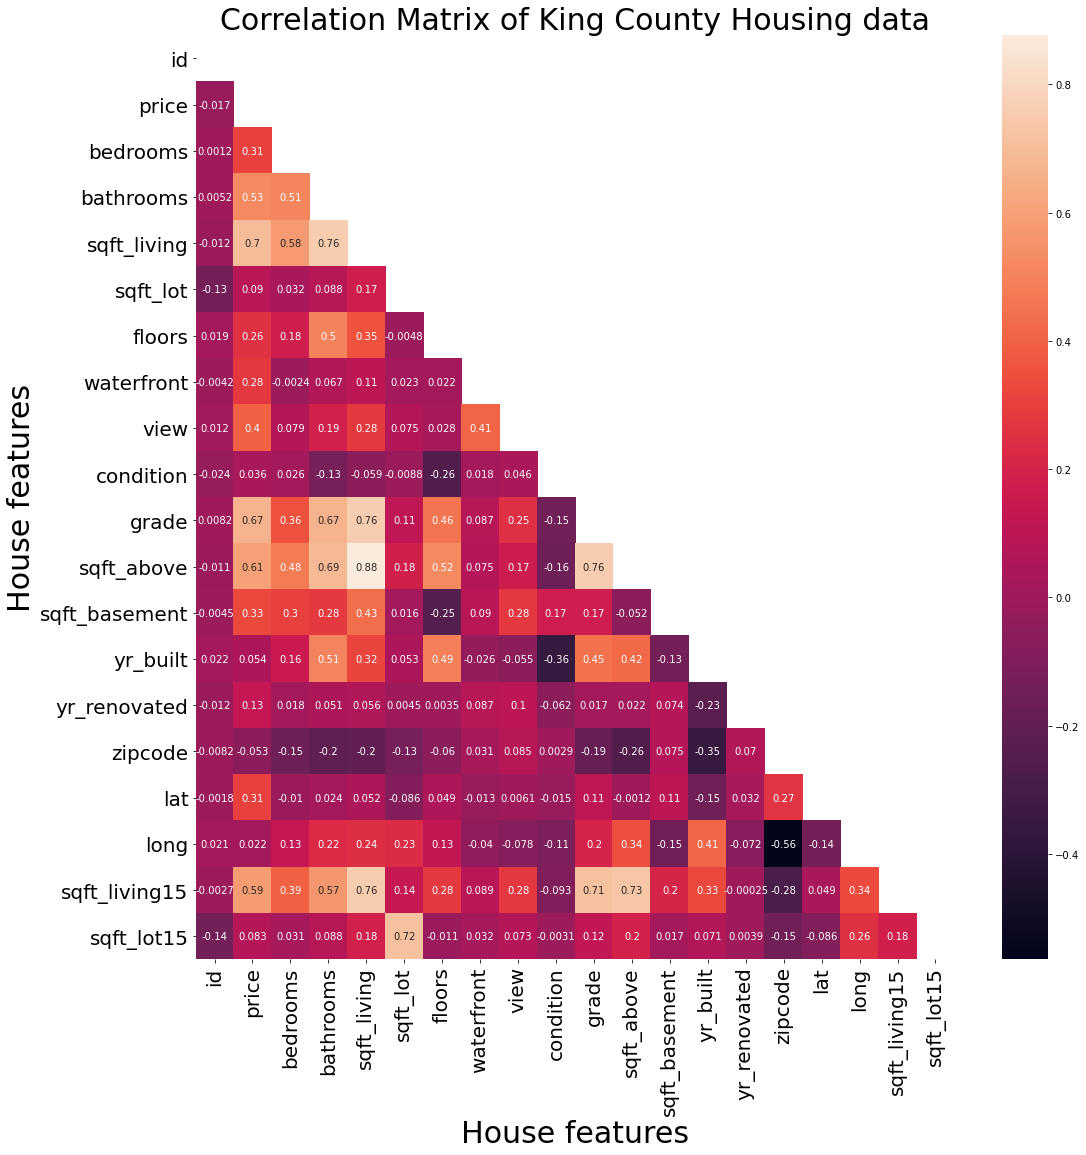

In [4]:
# correlation matrix with duplicated removed
corrMatrix = df.corr()
matrix = np.triu(corrMatrix)

# plot correlation matrix in heat map with seaborn
fig, ax = plt.subplots(figsize=(17,17)) 
sns.heatmap(corrMatrix, annot=True, mask=matrix)

# label plot
plt.title('Correlation Matrix of King County Housing data', size=30)
plt.xlabel('House features', size=30)
plt.ylabel('House features', size=30)
plt.xticks(size=20)
plt.yticks(size=20);

## Modeling

Create a regression model that uses ordinary least squares to asses the predicitve power of the mean square footage of a zipcode with the mean sales price of its houses.

In [5]:
# group mean price and square footage by zipcode
zipcode_df = df[['zipcode', 'price','sqft_living']]
zipcode_df = zipcode_df.groupby(['zipcode']).mean().sort_values('price', ascending=False).round(2)

In [6]:
# fit model and print summary statistics  
model_price_sqft = ols(formula='price ~ sqft_living', data=zipcode_df).fit() 
model_price_sqft.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     95.97
Date:                Fri, 19 Nov 2021   Prob (F-statistic):           1.26e-14
Time:                        09:27:53   Log-Likelihood:                -951.38
No. Observations:                  70   AIC:                             1907.
Df Residuals:                      68   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.561e+05   1.16e+05     -4.777      0.000   -7.88e+05   -3.24e+05
sqft_living   532.2587     54.332      9.796      0.000     423.841     640.676
==============================================================================
Omnibus:                       11.344   Durbin-Watson:                   1.114
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.497
Skew:                           0.908   Prob(JB):                      0.00319
Kurtosis:                       3.801   Cond. No.                     1.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Results analysis:
When grouped by Zip Code, the correlation between average sales price and average square footage is 0.77. This is .07 higher than when not grouped. This is why, when put into the regression model, average square footage explains 59% of the varinace in sales. 

In [7]:
print(f'''
Correlation before grouped: {df.price.corr(df.sqft_living):.2f}
Correlation grouped by zip code: {zipcode_df.price.corr(zipcode_df.sqft_living):.2f}
R-squared of model: {model_price_sqft.rsquared:.0%}
''')


Correlation before grouped: 0.70
Correlation grouped by zip code: 0.77
R-squared of model: 59%



Testing normality of the residual errors for the above model. 

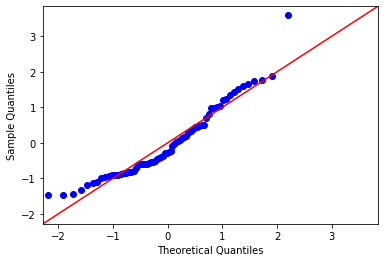

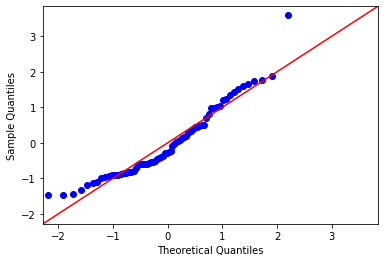

In [8]:
# list residual errors than plot
residuals = model_price_sqft.resid
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

Testing the above model for variance and heteroscedasticity to ensure the assumptions of ordinary least squares are not violated. 

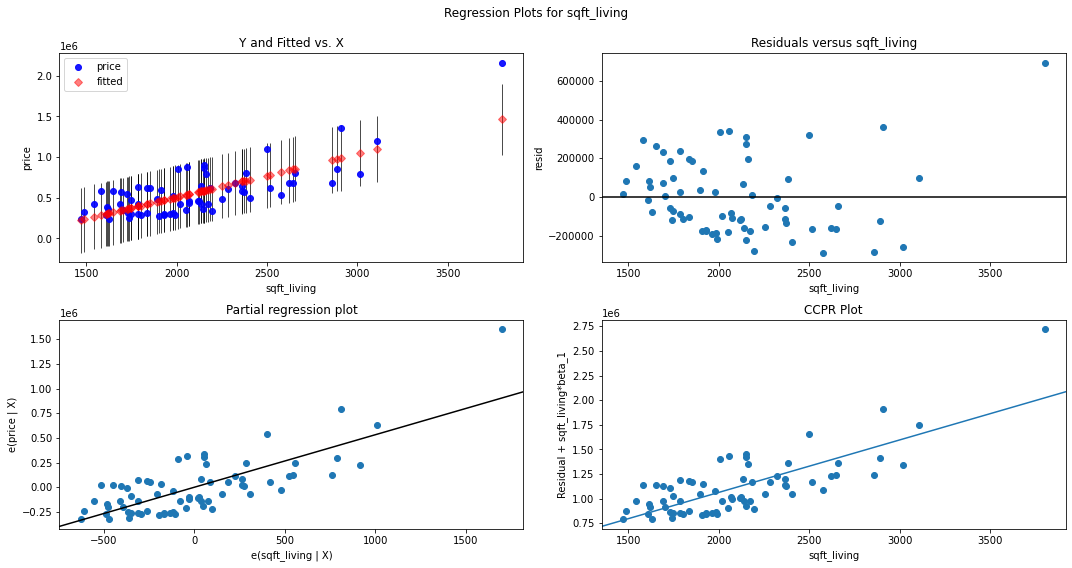

In [9]:
# plot analysis of model results 
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model_price_sqft, "sqft_living", fig=fig)
plt.show()

In [10]:
formula = 'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + yr_built + yr_renovated'
#Included everything about the house, not the date or the neighborhood.
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2444.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        09:27:54   Log-Likelihood:            -2.1162e+05
No. Observations:               15429   AIC:                         4.233e+05
Df Residuals:                   15416   BIC:                         4.234e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.742e+06   1.65e+05     40.749      0.000    6.42e+06    7.07e+06
bedrooms      -4.026e+04   2405.811    -16.735      0.000    -4.5e+04   -3.55e+04
bathrooms      4.871e+04   4194.097     11.615      0.000    4.05e+04    5.69e+04
sqft_living     117.9533      2.728     43.231      0.000     112.605     123.301
sqft_lot         -0.2691      0.043     -6.230      0.000      -0.354      -0.184
floors         2.317e+04   4495.484      5.154      0.000    1.44e+04     3.2e+04
waterfront     6.116e+05   2.24e+04     27.264      0.000    5.68e+05    6.56e+05
view           4.572e+04   2726.508     16.768      0.000    4.04e+04    5.11e+04
condition      1.806e+04   2989.985      6.040      0.000    1.22e+04    2.39e+04
grade          1.209e+05   2607.117     46.377      0.000    1.16e+05    1.26e+05
sqft_above       61.6652      2.619     23.544      0.000      56.531      66.799
sqft_basement    56.2881      3.317     16.968      0.000      49.786      62.791
yr_built      -3649.8002     84.875    -43.002      0.000   -3816.165   -3483.435
yr_renovated     10.0322      4.744      2.115      0.034       0.733      19.331
==============================================================================
Omnibus:                    11774.273   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           893408.218
Skew:                           3.062   Prob(JB):                         0.00
Kurtosis:                      39.772   Cond. No.                     1.11e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.51e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [11]:
formula = 'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement'
#dropped a few categories, no relevant change in the data, still violates assumptions.
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     2918.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        09:27:54   Log-Likelihood:            -2.5827e+05
No. Observations:               18749   AIC:                         5.166e+05
Df Residuals:                   18738   BIC:                         5.166e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.361e+05   1.24e+04    -27.049      0.000    -3.6e+05   -3.12e+05
bedrooms      -3.595e+04   2339.163    -15.369      0.000   -4.05e+04   -3.14e+04
bathrooms     -1.553e+04   3792.901     -4.096      0.000    -2.3e+04   -8099.889
sqft_living     138.3327      2.592     53.371      0.000     133.252     143.413
sqft_lot         -0.3529      0.043     -8.267      0.000      -0.437      -0.269
floors        -2659.0747   4278.517     -0.621      0.534    -1.1e+04    5727.207
waterfront      6.04e+05   2.15e+04     28.055      0.000    5.62e+05    6.46e+05
view            6.03e+04   2592.630     23.257      0.000    5.52e+04    6.54e+04
condition      5.475e+04   2739.901     19.981      0.000    4.94e+04    6.01e+04
grade          1.028e+05   2456.150     41.843      0.000     9.8e+04    1.08e+05
sqft_above       55.5656      2.514     22.102      0.000      50.638      60.493
sqft_basement    82.7671      3.169     26.120      0.000      76.556      88.978
==============================================================================
Omnibus:                    13725.867   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           842730.975
Skew:                           2.935   Prob(JB):                         0.00
Kurtosis:                      35.315   Cond. No.                     8.49e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.97e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [12]:
formula4 = 'price ~ sqft_living'
#testing individuals to see how they correlate, and which assumptions they violate individually
#sqft_living, while a key factor and statistically significant to price, is not a normal distribution, 
#and there is clear collinearity issues.
liv_mod = ols(formula=formula4, data=df).fit()
liv_mod_sum = liv_mod.summary()

liv_mod_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        09:27:54   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
formula1 = 'price ~ bedrooms'
#Bedrooms is not a normal distribution, BUT it does not have collinearity issues on the surface level, due to the 
#coef vs std err AND Cond. No. being between 10-30. Statistically significant according to the model, but only accounts for
#(almost) 10% of the data
bed_mod = ols(formula=formula1, data=df).fit()
bed_mod_sum = bed_mod.summary()

bed_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     2276.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        09:27:54   Log-Likelihood:            -3.0631e+05
No. Observations:               21597   AIC:                         6.126e+05
Df Residuals:                   21595   BIC:                         6.126e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.272e+05   8979.293     14.166      0.000     1.1e+05    1.45e+05
bedrooms    1.225e+05   2566.930     47.709      0.000    1.17e+05    1.27e+05
==============================================================================
Omnibus:                    18831.341   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1195104.832
Skew:                           3.900   Prob(JB):                         0.00
Kurtosis:                      38.598   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
formula3 = 'price ~ bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+sqft_above+sqft_basement'
#It seems if we are just going to accept the fact that our LINEAR model is going to have issues with assumptions.
#It would be best to include more data so we atleast have a higher R-Squared and can account for more variance within our model
room_mod = ols(formula=formula3, data=df).fit()
room_mod_sum = room_mod.summary()

room_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     2918.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        09:27:54   Log-Likelihood:            -2.5827e+05
No. Observations:               18749   AIC:                         5.166e+05
Df Residuals:                   18738   BIC:                         5.166e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.361e+05   1.24e+04    -27.049      0.000    -3.6e+05   -3.12e+05
bedrooms      -3.595e+04   2339.163    -15.369      0.000   -4.05e+04   -3.14e+04
bathrooms     -1.553e+04   3792.901     -4.096      0.000    -2.3e+04   -8099.889
sqft_living     138.3327      2.592     53.371      0.000     133.252     143.413
sqft_lot         -0.3529      0.043     -8.267      0.000      -0.437      -0.269
floors        -2659.0747   4278.517     -0.621      0.534    -1.1e+04    5727.207
waterfront      6.04e+05   2.15e+04     28.055      0.000    5.62e+05    6.46e+05
view            6.03e+04   2592.630     23.257      0.000    5.52e+04    6.54e+04
condition      5.475e+04   2739.901     19.981      0.000    4.94e+04    6.01e+04
grade          1.028e+05   2456.150     41.843      0.000     9.8e+04    1.08e+05
sqft_above       55.5656      2.514     22.102      0.000      50.638      60.493
sqft_basement    82.7671      3.169     26.120      0.000      76.556      88.978
==============================================================================
Omnibus:                    13725.867   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           842730.975
Skew:                           2.935   Prob(JB):                         0.00
Kurtosis:                      35.315   Cond. No.                     8.49e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.97e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [15]:
formula2 = 'price ~ bathrooms'
#Like bedrooms, not a normal distribution, but it doesnt seem to have collinearity AND its statistically significant while holding
#a solid R-Squared score.
bath_mod = ols(formula=formula2, data=df).fit()
bath_mod_sum = bath_mod.summary()

bath_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     8256.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        09:27:54   Log-Likelihood:            -3.0389e+05
No. Observations:               21597   AIC:                         6.078e+05
Df Residuals:                   21595   BIC:                         6.078e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8712.6518   6224.769      1.400      0.162   -3488.356    2.09e+04
bathrooms   2.512e+05   2765.054     90.863      0.000    2.46e+05    2.57e+05
==============================================================================
Omnibus:                    17251.570   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           882735.889
Skew:                           3.452   Prob(JB):                         0.00
Kurtosis:                      33.550   Cond. No.                         7.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After looking over some of the base models and how some of the independent variable correlated to price, it is time to build visualizations

In [16]:
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model', 'Final Model']
models_num = np.array([0.095, 0.277, 0.493, 0.609, 0.609, 0.655])

### Visualizations

### Plotting the regression of the model.

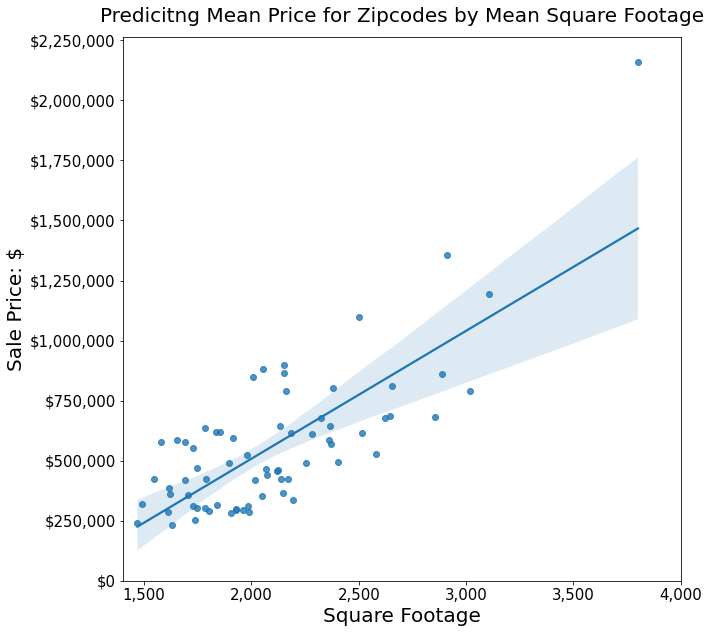

In [17]:
# plot
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.regplot(x=zipcode_df.sqft_living.values, y=zipcode_df.price.values)

# title
plt.title('Predicitng Mean Price for Zipcodes by Mean Square Footage', size=20, pad=15)

# x axis
x_ticks = [1500, 2000, 2500, 3000, 3500, 4000]
x_labels = ['1,500', '2,000', '2,500', '3,000', '3,500', '4,000']
plt.xlabel('Square Footage', size=20)
plt.xticks(x_ticks, x_labels, size=15)
ax.set_xlim(1400,4000)

# y axis 
plt.ylabel('Sale Price: $', size=20)
y_ticks = [0, 250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000, 2000000, 2250000]
y_labels = ['$0', '$250,000', '$500,000', '$750,000', '$1,000,000', '$1,250,000', '$1,500,000', 
          '$1,750,000', '$2,000,000', '$2,250,000']
plt.yticks(y_ticks, y_labels, size=15);

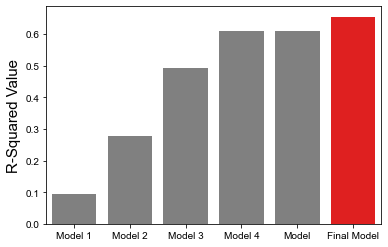

In [18]:
clrs = ['grey' if (x < max(models_num)) else 'red' for x in models_num ]
sns.barplot(x=models, y=models_num, palette=clrs)
plt.ylabel('R-Squared Value', size=15)
sns.set_style('dark')


### Creating Map

Make DataFrame for map

In [19]:
# make searies for residual errors
zipcode_erros = model_price_sqft.resid.round(2).rename('residual_error')

# attach erros to zipcode DataFrame 
map_df = zipcode_df.join(zipcode_erros, on=zipcode_erros.index).reset_index()
map_df.zipcode = map_df.zipcode.astype('str')

Make a GEO file of the zipcode's area in our model. 

In [20]:
# load GeoJSON
geo_data_file = 'data/zipcode_area_king_county_.geojson'
with open(geo_data_file, 'r') as jsonFile:
    geo_data = json.load(jsonFile)
    
tmp = geo_data

# create list of only relevent zipcodes
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZIPCODE'] in list(map_df['zipcode']):
        geozips.append(tmp['features'][i])
        
# create new JSON object for areas
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# create final file and write data into it
open("data/cleaned_geodata.json", "w").write(json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': ')))

12460416

Create function that makes a folium map for our data with each zip code as a different region, shaded for the amount of error in the model for that zip code.

In [21]:
# function signiture 
def map_feature_by_zipcode(zipcode_data, col):

    # geo data
    zipcode_area_geo = 'data/cleaned_geodata.json'

    # map
    m = folium.Map(location=[47.35, -121.9], zoom_start=9,
                   detect_retina=True, control_scale=False)
    # choropleth 
    m.choropleth(
        geo_data=zipcode_area_geo,
        name='choropleth',
        data=map_df,
        columns=['zipcode', col],
        key_on='feature.properties.ZIPCODE',
        fill_color='OrRd',
        fill_opacity=0.9,
        line_opacity=0.2,
        legend_name='house ' + col
    )

    folium.LayerControl().add_to(m)

    return m

Plot the map

In [22]:
zipcode_map = map_feature_by_zipcode(map_df, 'residual_error')
zipcode_map

C:\Users\Colin\anaconda3\envs\learn-env\lib\site-packages\folium\folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


### Insight: Features are related to the actual house and the area in which the house is located. Three models will be built for price: Inferential, Predictive, and a model based upon area.

In [23]:
df.fillna(0, inplace=True)
df.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         0.0   0.0  ...      4        1180            0.0   
1      7242     2.0         0.0   0.0  ...      4        2170          400.0   
2     10000     1.0         0.0   0.0  ...      3         770            0.0   
3      5000     1.0         0.0   0.0  ...      4        1050          910.0   
4      8080     1.0         0.0   0.0  ...      5        1680            0.0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955           0.0    98178  47.5112 -122.257           1340   
1      1951        1991.0    98125  47.7210 -122.319           1690   
2      1933           0.0    98028  47.7379 -122.233           2720   
3      1965           0.0    98136  47.5208 -122.393           1360   
4      1987           0.0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

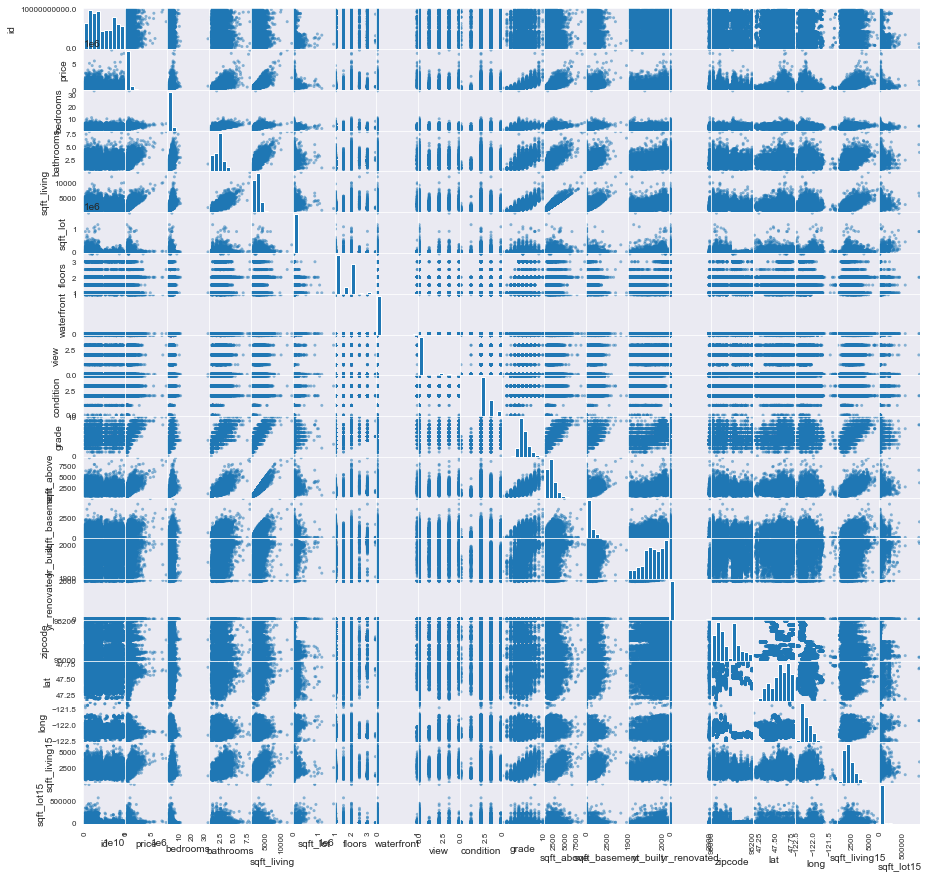

In [24]:
pd.plotting.scatter_matrix(df, figsize=[15, 15]);

plt.show()

In [25]:
df.corr()

id     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id             1.000000 -0.016772  0.001150   0.005162    -0.012241 -0.131911   
price         -0.016772  1.000000  0.308787   0.525906     0.701917  0.089876   
bedrooms       0.001150  0.308787  1.000000   0.514508     0.578212  0.032471   
bathrooms      0.005162  0.525906  0.514508   1.000000     0.755758  0.088373   
sqft_living   -0.012241  0.701917  0.578212   0.755758     1.000000  0.173453   
sqft_lot      -0.131911  0.089876  0.032471   0.088373     0.173453  1.000000   
floors         0.018608  0.256804  0.177944   0.502582     0.353953 -0.004814   
waterfront    -0.003599  0.264306 -0.002127   0.063629     0.104637  0.021459   
view           0.011772  0.393497  0.078354   0.186016     0.281715  0.075054   
condition     -0.023803  0.036056  0.026496  -0.126479    -0.059445 -0.008830   
grade          0.008188  0.667951  0.356563   0.665838     0.762779  0.114731   
sqft_above    -0.010799  0.605368  0.479386   0.686668     0.876448  0.184139   
sqft_basement -0.004359  0.321108  0.297229   0.278485     0.428660  0.015031   
yr_built       0.021617  0.053953  0.155670   0.507173     0.318152  0.052946   
yr_renovated  -0.010612  0.117855  0.017900   0.047177     0.051060  0.004979   
zipcode       -0.008211 -0.053402 -0.154092  -0.204786    -0.199802 -0.129586   
lat           -0.001798  0.306692 -0.009951   0.024280     0.052155 -0.085514   
long           0.020672  0.022036  0.132054   0.224903     0.241214  0.230227   
sqft_living15 -0.002701  0.585241  0.393406   0.569884     0.756402  0.144763   
sqft_lot15    -0.138557  0.082845  0.030690   0.088303     0.184342  0.718204   

                 floors  waterfront      view  condition     grade  \
id             0.018608   -0.003599  0.011772  -0.023803  0.008188   
price          0.256804    0.264306  0.393497   0.036056  0.667951   
bedrooms       0.177944   -0.002127  0.078354   0.026496  0.356563   
bathrooms      0.502582    0.063629  0.186016  -0.126479  0.665838   
sqft_living    0.353953    0.104637  0.281715  -0.059445  0.762779   
sqft_lot      -0.004814    0.021459  0.075054  -0.008830  0.114731   
floors         1.000000    0.020797  0.028414  -0.264075  0.458794   
waterfront     0.020797    1.000000  0.380543   0.016648  0.082818   
view           0.028414    0.380543  1.000000   0.045622  0.249082   
condition     -0.264075    0.016648  0.045622   1.000000 -0.146896   
grade          0.458794    0.082818  0.249082  -0.146896  1.000000   
sqft_above     0.523989    0.071778  0.166017  -0.158904  0.756073   
sqft_basement -0.241866    0.083050  0.270629   0.168482  0.165843   
yr_built       0.489193   -0.024487 -0.054452  -0.361592  0.447865   
yr_renovated   0.003793    0.073939  0.090339  -0.055808  0.015623   
zipcode       -0.059541    0.028923  0.085059   0.002888 -0.185771   
lat            0.049239   -0.012157  0.006321  -0.015102  0.113575   
long           0.125943   -0.037628 -0.077702  -0.105877  0.200341   
sqft_living15  0.280102    0.083823  0.278928  -0.093072  0.713867   
sqft_lot15    -0.010722    0.030658  0.073083  -0.003126  0.120981   

               sqft_above  sqft_basement  yr_built  yr_renovated   zipcode  \
id              -0.010799      -0.004359  0.021617     -0.010612 -0.008211   
price            0.605368       0.321108  0.053953      0.117855 -0.053402   
bedrooms         0.479386       0.297229  0.155670      0.017900 -0.154092   
bathrooms        0.686668       0.278485  0.507173      0.047177 -0.204786   
sqft_living      0.876448       0.428660  0.318152      0.051060 -0.199802   
sqft_lot         0.184139       0.015031  0.052946      0.004979 -0.129586   
floors           0.523989      -0.241866  0.489193      0.003793 -0.059541   
waterfront       0.071778       0.083050 -0.024487      0.073939  0.028923   
view             0.166017       0.270629 -0.054452      0.090339  0.085059   
condition       -0.158904       0.168482 -0.361592     -0.055808  0.

In [26]:
abs(df.corr()) > 0.75

id  price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id              True  False     False      False        False     False   
price          False   True     False      False        False     False   
bedrooms       False  False      True      False        False     False   
bathrooms      False  False     False       True         True     False   
sqft_living    False  False     False       True         True     False   
sqft_lot       False  False     False      False        False      True   
floors         False  False     False      False        False     False   
waterfront     False  False     False      False        False     False   
view           False  False     False      False        False     False   
condition      False  False     False      False        False     False   
grade          False  False     False      False         True     False   
sqft_above     False  False     False      False         True     False   
sqft_basement  False  False     False      False        False     False   
yr_built       False  False     False      False        False     False   
yr_renovated   False  False     False      False        False     False   
zipcode        False  False     False      False        False     False   
lat            False  False     False      False        False     False   
long           False  False     False      False        False     False   
sqft_living15  False  False     False      False         True     False   
sqft_lot15     False  False     False      False        False     False   

               floors  waterfront   view  condition  grade  sqft_above  \
id              False       False  False      False  False       False   
price           False       False  False      False  False       False   
bedrooms        False       False  False      False  False       False   
bathrooms       False       False  False      False  False       False   
sqft_living     False       False  False      False   True        True   
sqft_lot        False       False  False      False  False       False   
floors           True       False  False      False  False       False   
waterfront      False        True  False      False  False       False   
view            False       False   True      False  False       False   
condition       False       False  False       True  False       False   
grade           False       False  False      False   True        True   
sqft_above      False       False  False      False   True        True   
sqft_basement   False       False  False      False  False       False   
yr_built        False       False  False      False  False       False   
yr_renovated    False       False  False      False  False       False   
zipcode         False       False  False      False  False       False   
lat             False       False  False      False  False       False   
long            False       False  False      False  False       False   
sqft_living15   False       False  False      False  False       False   
sqft_lot15      False       False  False      False  False       False   

               sqft_basement  yr_built  yr_renovated  zipcode    lat   long  \
id                     False     False         False    False  False  False   
price                  False     False         False    False  False  False   
bedrooms               False     False         False    False  False  False   
bathrooms              False     False         False    False  False  False   
sqft_living            False     False         False    False  False  False   
sqft_lot               False     False         False    False  False  False   
floors                 False     False         False    False  False  False   
waterfront             False     False         False    False  False  False   
view                   False     False         False    False  False  False   
condition              False     False         False    False  False  False   
grade             

### Insight: sqft_living is also highly correlated with bathrooms, grade, sqft_above, and sqft_living15. These features will be dropped from the predictive model due to collinearity.

## MODEL CREATION (SKLEARN, predictive)

In [27]:
y = df[['price']]
X = df.drop(['id', 'price', 'date', 'bathrooms', 'grade', 'sqft_above', 'sqft_living15'], axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42)

In [29]:
#create dummy regressor as baseline
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dy_pred = dummy.predict(X_train)
dy_pred_test = dummy.predict(X_test)

In [30]:
dummy.score(X_train, y_train)

0.0

In [31]:
#linear regression model with no feature adjustments
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)

0.6624869705567367

In [32]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)

In [33]:
linreg.score(X_test, y_test)

0.6611935531140424

In [34]:
r2_score(y_test, y_pred_test)

0.6611935531140424

In [35]:
RMSE_train = mean_squared_error(y_train, y_pred, squared=False)
RMSE_test = mean_squared_error(y_test, y_pred_test, squared=False)
print('RMSE for test set is: ', RMSE_test)
print("RMSE for training set is: ", RMSE_train)

RMSE for test set is:  210043.12698093432
RMSE for training set is:  214324.32495325193


## QQ plot for sklearn model

### INSIGHT: To get a QQ plot for sklearn, we must do y_train - y_pred to calculate residuals. 

In [36]:
y_pred.shape

(17277, 1)

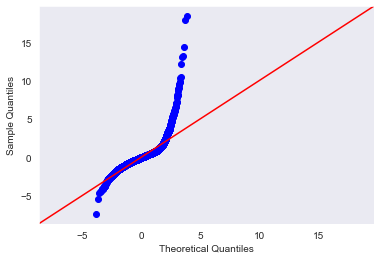

In [37]:
#qq plot of residuals
resid1 = y_train - y_pred

fig = sm.graphics.qqplot(resid1['price'], dist=stats.norm, line='45', fit=True)

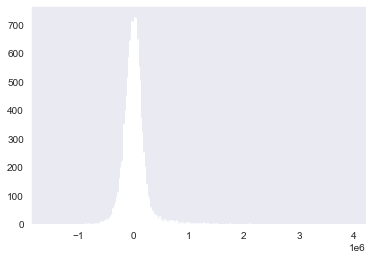

In [38]:
#hist plot of residuals
plt.hist(resid1['price'], bins='auto')
plt.show()

C:\Users\Colin\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


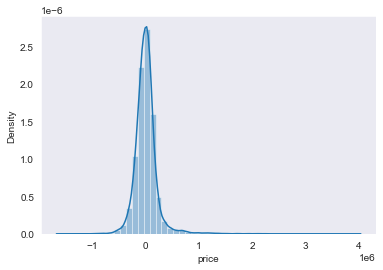

In [39]:
sns.distplot(resid1['price']);

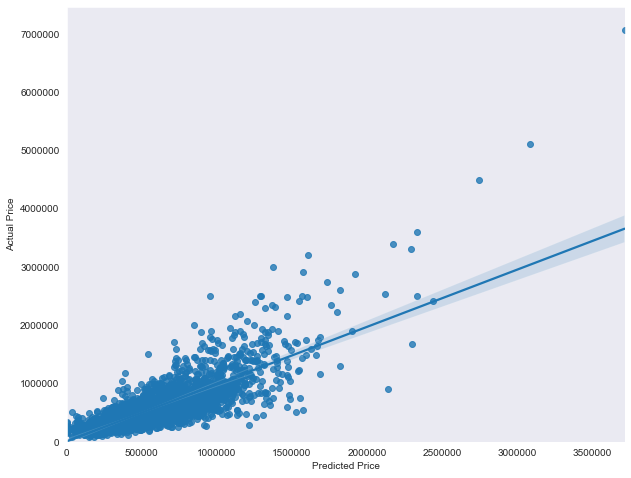

In [40]:
#visualizing predicted price vs actual price
fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(x=y_pred_test, y=y_test, data=df)
ax.set_xlabel("Predicted Price")
ax.set_ylabel("Actual Price")
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.ticklabel_format(useOffset=False, style='plain')
plt.show();

In [41]:
#examining skew and kurtosis of sklearn model

from scipy.stats import kurtosis, skew
print(skew(resid1))
print(kurtosis(resid1))

[2.93596039]
[31.15108497]


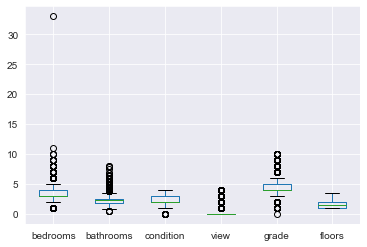

In [42]:
#boxplot of various features to examine outliers
df.boxplot(column = ['bedrooms', 'bathrooms', 'condition', 'view', 'grade', 'floors']);

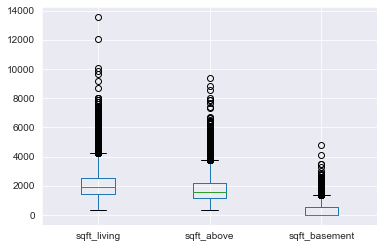

In [43]:
#sqft outliers
df.boxplot(column=['sqft_living', 'sqft_above', 'sqft_basement']);

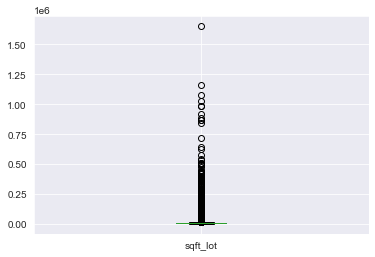

In [44]:
df.boxplot(column='sqft_lot');

### Insight: The model is severely affected by outliers. We will remove the outliers in the data and re-test the model.

In [45]:
#dropping outliers from key features related to the house itself

total_drop = []
for col in ['sqft_living', 'bedrooms', 'sqft_lot', 'sqft_above', 'bathrooms', 'floors']:
    to_drop = np.where(np.abs(stats.zscore(df[col])) > 1.96)[0].tolist()
    total_drop.extend(to_drop)
    
drop_idx = list(set(total_drop))


df2 = df.drop(to_drop)
df2.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         0.0   0.0  ...      4        1180            0.0   
1      7242     2.0         0.0   0.0  ...      4        2170          400.0   
2     10000     1.0         0.0   0.0  ...      3         770            0.0   
3      5000     1.0         0.0   0.0  ...      4        1050          910.0   
4      8080     1.0         0.0   0.0  ...      5        1680            0.0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955           0.0    98178  47.5112 -122.257           1340   
1      1951        1991.0    98125  47.7210 -122.319           1690   
2      1933           0.0    98028  47.7379 -122.233           2720   
3      1965           0.0    98136  47.5208 -122.393           1360   
4      1987           0.0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [46]:
#including all features for model improvement

y1 = df2[['price']]
X1 = df2.drop(['id', 'price', 'date'], axis=1)


In [47]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,
                                                   random_state=42)

In [48]:
linreg = LinearRegression()
linreg.fit(X1_train, y1_train)
y1_pred = linreg.predict(X1_train)
y1_pred_test = linreg.predict(X1_test)

In [49]:
r2_score(y1_test, y1_pred_test)

0.6902065365422461

In [50]:
#RMSE of outlier free model

RMSE_train = mean_squared_error(y1_train, y1_pred, squared=False)
RMSE_test = mean_squared_error(y1_test, y1_pred_test, squared=False)
print('RMSE for test set is: ', RMSE_test)
print("RMSE for training set is: ", RMSE_train)

RMSE for test set is:  195547.4583437861
RMSE for training set is:  203314.4957545998


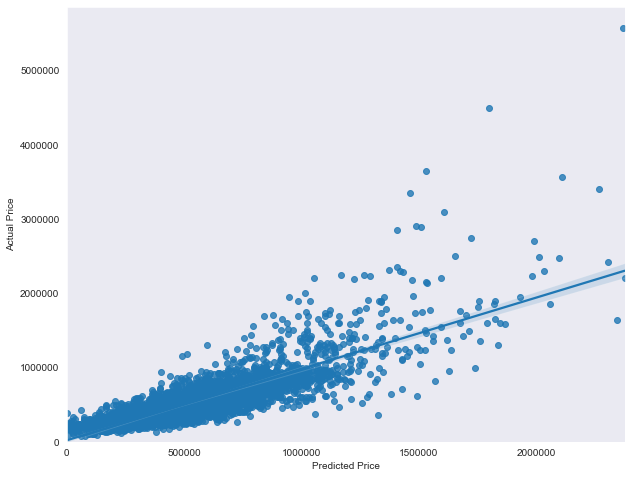

In [51]:
#actual price vs predicted price
fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(x=y1_pred_test, y=y1_test, data=df)
ax.set_xlabel("Predicted Price")
ax.set_ylabel("Actual Price")
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.ticklabel_format(useOffset=False, style='plain')

plt.show();

### Insight: removing outliers improved the RMSE overall. Will scaling the features improve the model?

In [52]:
#standard scaler
scaler = StandardScaler()

In [53]:
scaler.fit(X1_train)

StandardScaler()

In [54]:
scaler.transform(X1_train)

array([[-1.48324435, -0.78917715, -1.16811018, ..., -0.97404424,
        -1.42663505, -0.33544689],
       [-0.4121506 , -1.4367002 , -1.21166034, ..., -1.17286864,
        -1.01926358, -0.19794044],
       [-0.4121506 , -0.46541563,  0.36703314, ..., -1.28648258,
         0.20285084, -0.17633017],
       ...,
       [ 0.65894316,  0.50586894,  1.36868693, ...,  0.2047004 ,
         1.06124072, -0.25707265],
       [-0.4121506 ,  0.18210742,  1.05294824, ...,  0.73726575,
         1.5413571 , -0.05381029],
       [-1.48324435, -1.4367002 , -1.34231084, ..., -1.10185993,
        -0.62644109, -0.29119024]])

In [55]:
#create X_train_scaled to store different models

regression = LinearRegression()
regression.fit(scaler.transform(X1_train), y1_train)
regression.score(scaler.transform(X1_test), y1_test)

0.6902065365422553

In [56]:
X_scale_train = scaler.transform(X1_train)
X_scale_test = scaler.transform(X1_test)


In [57]:
y_scale_pred = regression.predict(X_scale_train)
y_scale_testpred = regression.predict(X_scale_test)
y_scale_pred.shape

(16783, 1)

In [58]:
print(r2_score(y1_test, y_scale_testpred))

0.6902065365422553


In [59]:
RMSE_train = mean_squared_error(y1_train, y_scale_pred, squared=False)
RMSE_test = mean_squared_error(y1_test, y_scale_testpred, squared=False)
print('RMSE for test set is: ', RMSE_test)
print("RMSE for training set is: ", RMSE_train)

RMSE for test set is:  195547.4583437832
RMSE for training set is:  203314.49575459966


### Insight: The model did not improve. Attempting MinMaxScaler method

In [60]:
#minmax scaler attempt
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
mmscaler.fit(X_train)

MinMaxScaler()

In [61]:
linreg2 = LinearRegression()
linreg2.fit(mmscaler.transform(X_train), y_train)
linreg2.score(mmscaler.transform(X_test), y_test)

0.6611935531140412

In [62]:
X_mmscale_train = mmscaler.transform(X_train)
X_mmscale_test = mmscaler.transform(X_test)

In [63]:
y_mmscale_pred = linreg2.predict(X_mmscale_train)
y_mmscale_testpred = linreg2.predict(X_mmscale_test)

In [64]:
r2_score(y_test, y_mmscale_testpred)

0.6611935531140412

In [65]:
RMSE_train = mean_squared_error(y_train, y_mmscale_pred, squared=False)
RMSE_test = mean_squared_error(y_test, y_mmscale_testpred, squared=False)
print('RMSE for test set is: ', RMSE_test)
print("RMSE for training set is: ", RMSE_train)

RMSE for test set is:  210043.1269809347
RMSE for training set is:  214324.32495325195


### Conclusions

Strongest feature, square footage,  performs best in suburbs outside of Seattle.

Despite transformations, standard and minmax scaling, and elimination of outliers, the models still all perform similarly, with varying RMSE between them. This indicates that a predictive linear regression model might not be the most effective model at predicting prices with the given features. The highest performing model is the one free of outliers before scaling and transformation.